In [63]:
import numpy as np
from matplotlib import  pyplot as plt
from numba import jit,njit 

# njit - ускоряет вычисления
@njit
def polynom(n_poly, y, proizvodnaya=False, poryadok=1):
    """
    n_ply - степень полинома,
    y - входящее значение,
    proizvodnaya - True/False, считаем производную или полином,
    poryadok - порядок производной
    """
    if n_poly == 0:
        if proizvodnaya:
            return 0
        else:
            return 1
    elif n_poly == 1:
        if proizvodnaya:
            if poryadok == 1 and n_poly == 1:
                return 1
            else:
                return 0
        else:
            return y
    elif not proizvodnaya:
        return 2*y*polynom(n_poly - 1, y) - polynom(n_poly - 2, y)
    else:
        if poryadok == 1:
            last_proizvodnaya = False
            poryadok_last_proizvodnaya = 1
        else:
            last_proizvodnaya = True
            poryadok_last_proizvodnaya = poryadok -1
        return 2*y*polynom(n_poly - 1, y, proizvodnaya, poryadok) - polynom(n_poly - 2, y, proizvodnaya, poryadok) + 2*poryadok*polynom(n_poly - 1, y, last_proizvodnaya, poryadok_last_proizvodnaya)

@njit
def tochnoe_reshenie(x):
    # точное решение исходного уравнения
    return x**2*(1-x)**2*np.exp(x)  
#     return np.exp(x)

@njit
def f(x):
    # исходное уравнение
    return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12)*np.exp(x)
#     return np.exp(x)

@njit
def kraevoe_uslovie(x, proizvodnaya=False):
    # краевые условия исходной системы
    if not proizvodnaya:
        return 0
#         return np.exp(x)
    else:
        return 0
#         return np.exp(x)

@njit
def cell(n_poly, n_eq, n_col, y, cell_type='inner'):
    """
    n_poly - степень полинома,
    n_eq - количество уравнений,
    n_col - колисчество уравнений коллокаций,
    y - исходное значение,
    cell_type - тип ячейки (правая, левая ил центральная)
    """
    matrix = np.zeros((n_eq, n_poly + 1)) # заводим матрицу количество уравнений x степень полинома + 1
    
    if cell_type == 'inner':
        # если ячейка центральная то считаем условия согласования с ячейками слева и справа
        # условия согласования
        matrix[-2] = [polynom(j, y[-1]) + polynom(j, y[-1], True, 1) for j in range(n_poly+1)]
        matrix[-1] = [polynom(j, y[-1], True, 2) + polynom(j, y[-1], True, 3) for j in range(n_poly+1)]
        # условия согласования
        matrix[0] = [polynom(j, y[0]) - polynom(j, y[0], 2) for j in range(n_poly+1)]
        matrix[1] = [polynom(j, y[0], True, 2) - polynom(j, y[0], True, 3) for j in range(n_poly+1)]
        
        # и считаем условия коллокаций
        # условия коллокаций 
        for i in range(2, n_col+2):
            matrix[i][4:n_poly+1] = [polynom(j, y[i-1], True, 4) for j in range(4, n_poly+1)]
    elif cell_type == 'left':
        # если ячейка слева, то с правой нужно посчитать условия согласований
        
        # условия согласования
        matrix[-2] = [polynom(j, y[-1]) + polynom(j, y[-1], True, 1) for j in range(n_poly+1)]
        matrix[-1] = [polynom(j, y[-1], True, 2) + polynom(j, y[-1], True, 3) for j in range(n_poly+1)]
        # условия коллокации
        for i in range(2, n_col+2):
            matrix[i][4:n_poly+1] = [polynom(j, y[i-1], True, 4) for j in range(4, n_poly+1)]
        
        # а слева граничные условия
        # граничные условия
        matrix[0] = [polynom(j, y[0]) for j in range(n_poly+1)]
        matrix[1] = [polynom(j, y[0], True, 1) for j in range(n_poly+1)]
    elif cell_type == 'right':
        # с правой ячейкой наоборот
        
        # граничные условия
        matrix[-2] = [polynom(j, y[-1]) for j in range(n_poly+1)]
        matrix[-1] = [polynom(j, y[-1], True, 1) for j in range(n_poly+1)]
        # условия согласования
        matrix[0] = [polynom(j, y[0]) - polynom(j, y[0], True, 1) for j in range(n_poly+1)]
        matrix[1] = [polynom(j, y[0], True, 2) - polynom(j, y[0], True, 3) for j in range(n_poly+1)]
        # условия коллокаций 
        for i in range(2, n_col+2):
            matrix[i][4:n_poly+1] = [polynom(j, y[i-1], True, 4) for j in range(4, n_poly+1)]
            
    return matrix

@njit
def rhs(cell_id, matrix, step, global_nodes, n_poly, n_eq, n_col, y, x0, x1):
    local_vector = np.zeros(n_eq)
    # проверка, какого типа ячейка
    if (cell_id == 0):
        # граничные условия
        local_vector[0] = kraevoe_uslovie(x0)
        local_vector[1] = kraevoe_uslovie(x0, True)*(step/2)
        # условия согласования
        local_vector[-2] = sum([matrix[cell_id+1, j]*polynom(j, -1) + matrix[cell_id+1, j]*polynom(j, -1, True, 1) for j in range(n_poly+1)])
        local_vector[-1] = sum([matrix[cell_id+1, j]*polynom(j, -1, True, 2) + matrix[cell_id+1, j]*polynom(j, -1, True, 3)  for j in range(n_poly+1)])
    elif (cell_id == len(global_nodes)-2):
        # условия согласования
        local_vector[0] = sum([matrix[cell_id-1, j]*polynom(j, 1) - matrix[cell_id-1, j]*polynom(j, 1, True, 1) for j in range(n_poly+1)])
        local_vector[1] = sum([matrix[cell_id-1, j]*polynom(j, 1, True, 2) - matrix[cell_id-1, j]*polynom(j, 1, True, 3)  for j in range(n_poly+1)])
        # граничные условия
        local_vector[-2] = kraevoe_uslovie(x1)
        local_vector[-1] = kraevoe_uslovie(x1, True)*(step/2)
    else:
        # условия согласования
        local_vector[0] = sum([matrix[cell_id-1, j]*polynom(j, 1) - matrix[cell_id-1, j]*polynom(j, 1, True, 1) for j in range(n_poly+1)])
        local_vector[1] = sum([matrix[cell_id-1, j]*polynom(j, 1, True, 2) - matrix[cell_id-1, j]*polynom(j, 1, True, 3) for j in range(n_poly+1)])
        # условия согласования
        local_vector[-2] = sum([matrix[cell_id+1, j]*polynom(j, -1) + matrix[cell_id+1, j]*polynom(j, -1, True, 1) for j in range(n_poly+1)])
        local_vector[-1] = sum([matrix[cell_id+1, j]*polynom(j, -1, True, 2) + matrix[cell_id+1, j]*polynom(j, -1, True, 3) for j in range(n_poly+1)])
    xc = (global_nodes[cell_id] + global_nodes[cell_id + 1])/2
    x = np.array([y[i] * step / 2 + xc for i in range(1, n_col+1)])
    local_vector[2:-2] = (step/2)**4*f(x)
    # возвращаем полученный вектор
    return local_vector

def iterations_over_subdomain(n_cells, n_poly, n_eq, n_col, x0, x1, y, pogreshnost=False):
    step = (x1-x0)/n_cells # Длина одной ячейки

    # Создаем массив узлов (границы ячеек) 
    global_nodes = np.linspace(x0, x1, n_cells+1) 

    matrix_coeffs = np.zeros((n_cells, n_poly+1), dtype = np.float64) # матрица коэффициентов для всех ячеек
    matrix_coeffs_old = np.zeros((n_cells, n_poly+1), dtype = np.float64) # матрица коэффициентов для хранения

    #создаем локальную  матрицу для центральной ячейки
    A_inner = cell(n_poly, n_eq, n_col, y, cell_type='inner')
    # создаем локальную  матрицу для левой граничной ячейки
    A_left = cell(n_poly, n_eq, n_col, y, cell_type='left')
    # создаем локальную  матрицу для правой граничной ячейки
    A_right = cell(n_poly, n_eq, n_col, y, cell_type='right')

    # print(A_left)
    # print(A_inner)
    # print(A_right)

    #Находим QR разложение локальных матриц
    Q_inner, R_inner = np.linalg.qr(A_inner)
    Q_left, R_left = np.linalg.qr(A_left)
    Q_right, R_right = np.linalg.qr(A_right)
    #Находим обратные для матриц R 
    R_inner_inv = np.linalg.inv(R_inner)
    R_left_inv = np.linalg.inv(R_left)
    R_right_inv = np.linalg.inv(R_right)

    # Считаем числа обусловленности локальной и граничных матриц
    cond_A_inner = np.linalg.cond(A_inner)
    cond_A_left = np.linalg.cond(A_left)

    n_iter = 0
    eps = 1
    # заполняем матрицу коэффициентов начальным приближением    
    matrix_coeffs.fill(0.4)
    
    if pogreshnost:
        epselons = []
    
    # цикл пока псевдопогрешность больше заданного значения
    while (eps > eps_val):
        # копируем матрицу коэффициентов
        matrix_coeffs_old = np.copy(matrix_coeffs)
        # обходим ячейки по порядку
        for i in range(n_cells):
            # проверка на тип ячейки
            if i == 0:
                # обновляем вектор правой части
                F_ = rhs(i, matrix_coeffs, step, global_nodes, n_poly, n_eq, n_col, y, x0, x1)
                # находим коэффициенты
                matrix_coeffs[i] = np.dot(R_left_inv, np.dot(Q_left.T, F_))  
            elif i == n_cells - 1:
                F_ = rhs(i, matrix_coeffs, step, global_nodes, n_poly, n_eq, n_col, y, x0, x1)
                matrix_coeffs[i] = np.dot(R_right_inv, np.dot(Q_right.T, F_))
            else:
                F_ = rhs(i, matrix_coeffs, step, global_nodes, n_poly, n_eq, n_col, y, x0, x1)
                matrix_coeffs[i] = np.dot(R_inner_inv, np.dot(Q_inner.T, F_))
                
        # обновляем значения псевдопогрешности
        eps = np.max(abs(matrix_coeffs - matrix_coeffs_old))
        if pogreshnost:
            epselons.append(eps)
        n_iter = n_iter + 1 # счетчик итераций

    print("Cells = ", n_cells, "Solution converged at Iteration: ", n_iter, "Eps:", eps)

    # Возвращаем массив в следующей последовательности: коэффициенты, узлы, кол-во итераций, обсуловленность центральной ячейки, обусл. гр. ячейки.
    if pogreshnost:
        return epselons
    else:
        return matrix_coeffs, global_nodes, n_iter, cond_A_inner, cond_A_left


@njit
def u(x, matrix, global_nodes):
    # переход в локальную систему  
    h = (global_nodes[1] - global_nodes[0])/2
    
    if (x == x0):
        cell_id = 0
    elif (x == x1):
        cell_id = len(global_nodes) - 2
    else:
        cell_id = int(x // (2*h)) 

    x_c = (global_nodes[cell_id] + global_nodes[cell_id+1])/2
    y = (x-x_c)/h # перешли в локальную систему в нужной ячейке
    # вычисляем значение искомой функции в точке y
    ans = sum([matrix[cell_id, i]*polynom(i, y) for i in range(n_poly+1)])
    return ans

In [48]:
import time
# решаем задачу на последовательности сеток, начиная с 5

n_cells=5

x0 = 0.0 
x1 = 1.0

n_poly = 4
n_col = n_poly + 1
n_eq = n_col + 4

eps_val = 1e-14

y = np.array([-np.cos(i / (n_col+1) * np.pi) for i in range(0, n_col+2)])

solution_array = []
error = []
error_abs = []
x_cor = np.linspace(x0, x1, 100)
u_ex = np.array([tochnoe_reshenie(i) for i in x_cor])

# засекаем время   
while n_cells < 161:
    # решаем задачу
    cur_time = time.time()   
    ans = iterations_over_subdomain(n_cells, n_poly, n_eq, n_col, x0, x1, y)
    print("Time in seconds:", time.time()-cur_time)
    cur_time = time.time()
    # сохраняем решение в массив решений
    solution_array.append(ans)
    # восстанавливаем решение
    u_ = np.array([u(i, ans[0], ans[1]) for i in x_cor])
    # вычисляем погрешность
    error_abs.append(np.max(abs(u_-u_ex)))  
    error.append(np.max(abs(u_-u_ex))/np.max(abs(u_ex)))  
    n_cells = n_cells*2

Cells =  5 Solution converged at Iteration:  89 Eps: 3.1537272793258353e-15
Time in seconds: 0.00683140754699707
Cells =  10 Solution converged at Iteration:  307 Eps: 7.216449660063518e-15
Time in seconds: 0.02425360679626465
Cells =  20 Solution converged at Iteration:  1136 Eps: 8.534839501805891e-15
Time in seconds: 0.16638541221618652
Cells =  40 Solution converged at Iteration:  4567 Eps: 9.769962616701378e-15
Time in seconds: 1.326570749282837
Cells =  80 Solution converged at Iteration:  18291 Eps: 9.936496070395151e-15
Time in seconds: 10.240785121917725
Cells =  160 Solution converged at Iteration:  73187 Eps: 9.992007221626409e-15
Time in seconds: 82.53772068023682


In [57]:
# Отрисовка решения
def plot_solution(solution, x0, x1, label):
    # достаточно мелкая сетка, для сравнения решений и отрисовки
    x_cor = np.arange(x0, x1, 0.01)
    # значение численного решения сетке
    u_ = np.array([u(i, solution[0], solution[1]) for i in x_cor])
    # значение точного решения на сетке
    u_ex = np.array([tochnoe_reshenie(i) for i in x_cor])
    # рисуем численное решение
    fig = plt.figure(figsize=(12,8), frameon=True)
    plt.style.use('ggplot')
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 15
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    ax = fig.add_subplot(111)    

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set(facecolor='w')
    ax.grid('axis = "both"', color = 'gray')

    ax.set_xlabel('$\\varepsilon$', labelpad = -10)
    ax.set_ylabel('$\\sigma$', rotation = 0, labelpad = 20)

    ax.plot(x_cor, u_, color = 'blue', linestyle = '-', linewidth = 3, label=f'Решение МКНК при K = {label}')
    #ax.plot(w_obr, P_obr, color = 'red', linestyle = '-', label = 'obrabotannoe')
    ax.plot(x_cor, u_ex, color = 'red', linestyle = '-', linewidth = 2, label = 'Точное решение')
    ax.legend(loc=2)

    plt.show()
names = [5, 10, 20, 40, 80, 160]

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

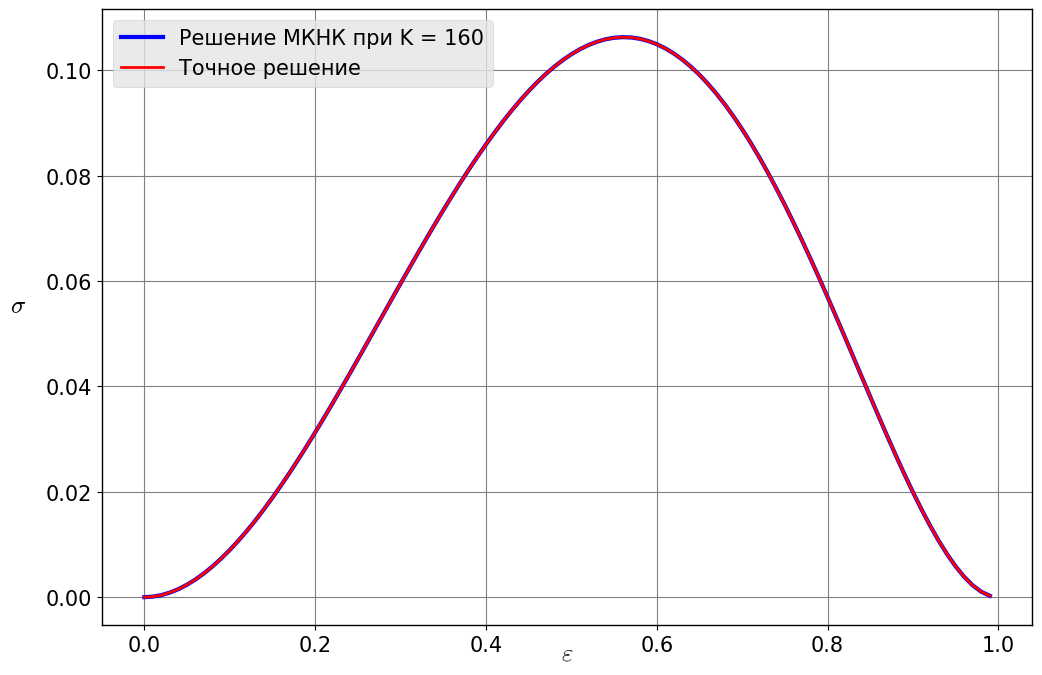

In [58]:

index_ = 5
plot_solution(solution_array[index_], x0, x1, names[index_])

In [59]:
import pandas as pd
x = []
field_names = ["Mesh", "Error_absolute", "Order abs", "Error_relative", "Order", "Iteration", "Cond_A_inner", "Cond_A_left"]

rate = [0]
rate_abs = [0]
for i in range(len(error)-1):
    rate.append(np.log2(error[i]/error[i+1]))
    rate_abs.append(np.log2(error_abs[i]/error_abs[i+1]))
for i in range(len(error)):
    x.append([5*2**(i), "{:2.2e}".format(error_abs[i]), "{:2.2e}".format(rate_abs[i]), "{:2.2e}".format(error[i]), "{:2.2e}".format(rate[i]), solution_array[i][2], "{:2.2e}".format(solution_array[i][3]), "{:2.2e}".format(solution_array[i][4])])
pd.DataFrame(x, columns = field_names)

,Mesh,Error_absolute,Order abs,Error_relative,Order,Iteration,Cond_A_inner,Cond_A_left
0,5,6.13e-03,0.00e+00,5.76e-02,0.00e+00,89,7.93e+02,4.66e+02
1,10,1.49e-03,2.04e+00,1.41e-02,2.04e+00,307,7.93e+02,4.66e+02
2,20,3.70e-04,2.01e+00,3.49e-03,2.01e+00,1136,7.93e+02,4.66e+02
3,40,9.24e-05,2.00e+00,8.70e-04,2.00e+00,4567,7.93e+02,4.66e+02
4,80,2.31e-05,2.00e+00,2.17e-04,2.00e+00,18291,7.93e+02,4.66e+02
5,160,5.77e-06,2.00e+00,5.43e-05,2.00e+00,73187,7.93e+02,4.66e+02


In [64]:

epselons = iterations_over_subdomain(160, n_poly, n_eq, n_col, x0, x1, y, True)

Cells =  160 Solution converged at Iteration:  73187 Eps: 9.992007221626409e-15


In [65]:
len(epselons)

73187

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

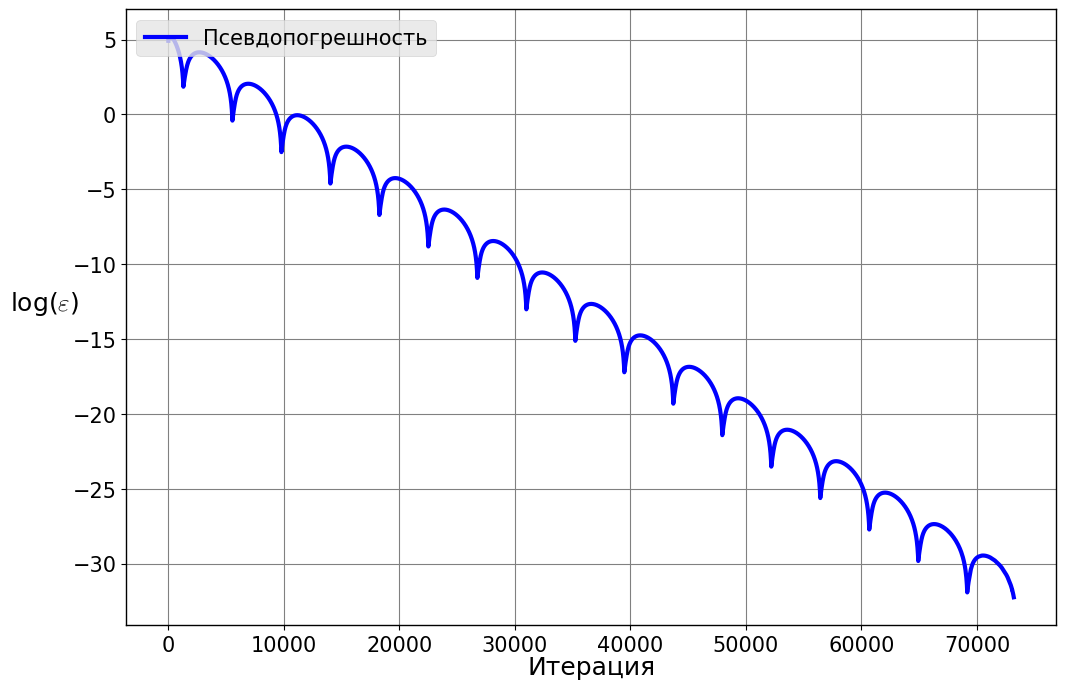

In [71]:
# Отрисовка решения
def plot_pogreshnost(epselons):
    # достаточно мелкая сетка, для сравнения решений и отрисовки
    # значение численного решения сетке
    # значение точного решения на сетке
    # рисуем численное решение
    
    y = np.log(np.array(epselons))
    x = np.arange(len(epselons))
    fig = plt.figure(figsize=(12,8), frameon=True)
    plt.style.use('ggplot')
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 15
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    ax = fig.add_subplot(111)    

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set(facecolor='w')
    ax.grid('axis = "both"', color = 'gray')

    ax.set_xlabel('Итерация', labelpad = 0)
    ax.set_ylabel('log($\\varepsilon$)', rotation = 0, labelpad = 20)

    ax.plot(x, y, color = 'blue', linestyle = '-', linewidth = 3, label=f'Псевдопогрешность')
    ax.legend(loc=2)

    plt.show()

plot_pogreshnost(epselons)